In [322]:
import odrive
from odrive.enums import *
import time, sys
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from tqdm import tnrange

In [501]:
def reboot():
    global my_drive 
    
    from fibre.protocol import ChannelBrokenException
    
    try:
        my_drive.reboot()
    except ChannelBrokenException:
        print('Rebooting.....')
    except AttributeError:
        print('Booting....')
        
    my_drive = odrive.find_any()
    print("serial:  ", hex(my_drive.serial_number))
    print("voltage: ", my_drive.vbus_voltage)
    print("version: %d.%d.%d" % (my_drive.fw_version_major, my_drive.fw_version_minor, my_drive.fw_version_revision))
    
reboot()

Rebooting.....
serial:   0x2067367c3548
voltage:  24.201343536376953
version: 0.4.1


In [405]:
def idle():
    my_drive.axis0.requested_state = AXIS_STATE_IDLE
    my_drive.axis1.requested_state = AXIS_STATE_IDLE

idle()

In [502]:
def index_search(i=3):
    if i < 1:
        my_drive.axis0.encoder.config.idx_search_speed = 3
        my_drive.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH
        return
    
    if i < 2:
        my_drive.axis1.encoder.config.idx_search_speed = 3
        my_drive.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH
    
index_search(0)

In [503]:
index_search(1)

In [326]:
def set_PID(pos_gain=5, vel_gain=0.0003, vel_integrator_gain=0):
    my_drive.axis0.controller.config.pos_gain = pos_gain
    my_drive.axis0.controller.config.vel_gain = vel_gain
    my_drive.axis0.controller.config.vel_integrator_gain = vel_integrator_gain
    
    my_drive.axis1.controller.config.pos_gain = pos_gain
    my_drive.axis1.controller.config.vel_gain = vel_gain
    my_drive.axis1.controller.config.vel_integrator_gain = vel_integrator_gain
    

In [507]:
def errors():
    print("axis0\t\t", hex(my_drive.axis0.error))
    print("axis0.motor\t", hex(my_drive.axis0.motor.error))
    print("axis0.encoder\t", hex(my_drive.axis0.encoder.error))
    print()
    print("axis1\t\t", hex(my_drive.axis1.error))
    print("axis1.motor\t", hex(my_drive.axis1.motor.error))
    print("axis1.encoder\t", hex(my_drive.axis1.encoder.error))
errors()

axis0		 0x41
axis0.motor	 0x90
axis0.encoder	 0x0

axis1		 0x41
axis1.motor	 0x90
axis1.encoder	 0x0


In [328]:
idle()

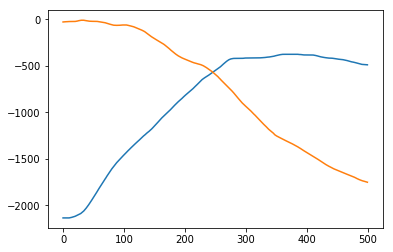

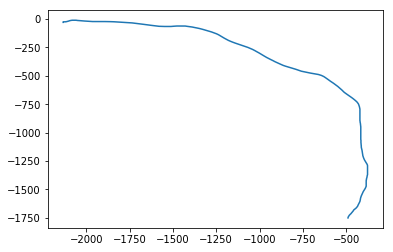

In [465]:
'''RECORD'''

trajectory = []
duration = 5 # seconds
dt = 0.01 # seconds
num = int(duration/dt)

for _ in range(num):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate

    trajectory.append([pos0, pos1])
    time.sleep(dt)
    
plt.plot(trajectory)
plt.show()
plt.plot(*np.array(trajectory).T)

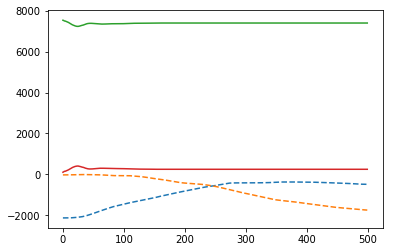

In [506]:
''' execute '''

set_PID(650, 2e-4, 2.5e-4)

trajectory_est = []
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

for point in trajectory:
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    trajectory_est.append([pos0, pos1])
    
    set0, set1 = point
    my_drive.axis0.controller.pos_setpoint = set0
    my_drive.axis1.controller.pos_setpoint = set1
    
    time.sleep(dt)
    
plt.plot(trajectory, '--')
plt.plot(trajectory_est)

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

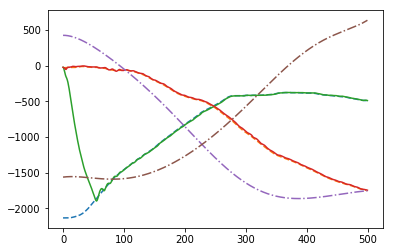

In [467]:
plt.plot(trajectory, '--')
plt.plot(trajectory_est)
_t = np.linspace(0,1,len(trajectory))
plt.plot(range(len(trajectory)), f(_t), '-.')

In [468]:
import cvxpy as cp
from autograd import numpy as np
from autograd import grad, jacobian

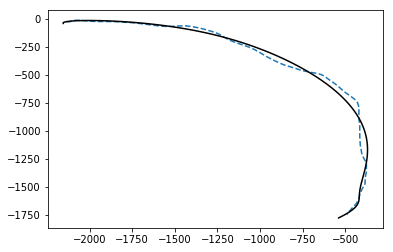

In [486]:
def poly_est(x, n=7):
    ''' Fit a polynomial [0,1] -> R^2 '''
    x = np.array(x)
    assert x.shape[0] > x.shape[1], "check dimensions!"
    t = np.linspace(0, 1, len(x))
    T = np.array([np.power(t,i) for i in range(n+1)]).T
    c = cp.Variable((n+1,2) )
    obj = cp.Minimize(cp.sum_squares(T @ c - x))
    prob = cp.Problem(obj)
    prob.solve()
    def f(t):
        t = np.array(t)
        assert np.all(t>=0) and np.all(t<=1)
        return (c.value.T @ np.array([t**i for i in range(n+1)])).T
    return f

trace = poly_est(trajectory)

plt.plot(*np.array(trajectory).T, '--')
plt.plot(*trace(np.linspace(0,1,100)).T, 'k')

In [489]:
def compute_grad(f):
    loss = lambda t: np.sum((f(t[0]) - t[1:3])**2)
    df = grad(loss)
    ddf = jacobian(df)
    
    return lambda t, point: df(np.hstack([t, point]))[0], lambda t,point: ddf(np.hstack([t, point]))[0,0]

df, ddf = compute_grad(trace)

In [490]:
def projection(point, df, ddf=None,t0=0.5, steps=100):
    t = t0
    for _ in range(steps):
        Δt = df(t, point)
        t -= 1/ddf(t,point)*Δt

        if t >= 1 or t <= 0:
            assert "Error"
        if np.allclose(0, Δt, atol=1e-2): 
            break

    return t

0.94	-462.05,-1687.39	dist:119.0082

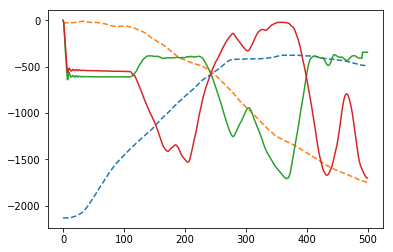

In [491]:
''' execute '''

set_PID(650, 2e-4, 2.5e-4)
param = 0.5
pos0 = my_drive.axis0.encoder.pos_estimate
pos1 = my_drive.axis1.encoder.pos_estimate


trajectory_est = []
trajectory_set = []
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

for point in trajectory:
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    trajectory_est.append([pos0, pos1])
    
    param = projection(np.array([pos0, pos1]), df, ddf, t0=param, steps=1)
    
    set0, set1 = f(param)
    sys.stdout.write("\r%.2f\t%.2f,%.2f\tdist:%.4f" % (param, set0, set1, np.linalg.norm([pos0-set0, pos1-set1])))

    my_drive.axis0.controller.pos_setpoint = set0     
    my_drive.axis1.controller.pos_setpoint = set1
    trajectory_set.append([set0, set1])
    
    time.sleep(dt)
    
plt.plot(trajectory, '--')
plt.plot(trajectory_est)

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

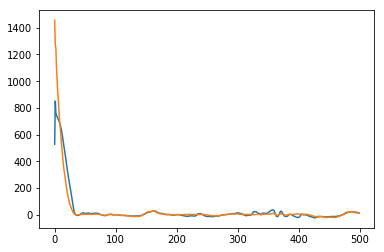

In [458]:
plt.plot(np.array(trajectory_est)-np.array(trajectory_set))


In [166]:
set_PID(20, 3e-4, 1e-4)

hold0 = my_drive.axis0.encoder.pos_estimate
hold1 = my_drive.axis1.encoder.pos_estimate
print("hold: ", hold0, hold1)

my_drive.axis0.controller.pos_setpoint = hold0
my_drive.axis1.controller.pos_setpoint = hold1

my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

for _ in range(30):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    trajectory.append([pos0, pos1])

    sys.stdout.write("\r\rcpr0: " + str(pos0) \
                      + " cpr1: " + str(pos1) \
              + "\t vel_setpoint" + str(my_drive.axis0.controller.vel_setpoint)) 
    time.sleep(0.1)
    
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

hold:  51.23451232910156 -21.150096893310547
cpr0: 33.04704666137695 cpr1: -3.057244300842285	 vel_setpoint0.0

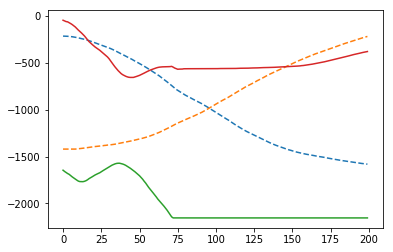

In [203]:
print()
print("hold: ", hold0, hold1)

my_drive.axis0.controller.pos_setpoint = hold0
# my_drive.axis1.controller.pos_setpoint = hold1


for _ in range(30):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    sys.stdout.write("\r\rcpr0: " + str(pos0) + " cpr1:" + str(pos1) + "\t vel_setpoint" + str(my_drive.axis0.controller.vel_setpoint)) 
    time.sleep(0.1)
    
    
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

hold:  1185.741943359375 -2394.087158203125
cpr0: 1037.1826171875 cpr1: -2118.956787109375	 vel_setpoint0.0
hold:  1185.741943359375 -2394.087158203125
cpr0: 1046.5732421875 cpr1:-2154.85546875	 vel_setpoint0.0

In [192]:
set_PID(21, 3e-4, 3e-5)

hold0 = my_drive.axis0.encoder.pos_estimate
hold1 = my_drive.axis1.encoder.pos_estimate

print("hold: ", hold0, hold1)

my_drive.axis0.controller.pos_setpoint = hold0
my_drive.axis1.controller.pos_setpoint = hold1

my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

for _ in range(30):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    
    sys.stdout.write("\r\rcpr0: " + str(pos0) + " cpr1:" + str(pos1) + "\t vel_setpoint" + str(my_drive.axis0.controller.vel_setpoint)) 
    time.sleep(0.1)

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

hold:  901.958984375 -2312.85400390625
cpr0: 1035.828125 cpr1:-2119.792724609375	 vel_setpoint0.0

In [173]:
# hold0 = my_drive.axis0.encoder.pos_estimate
# hold1 = my_drive.axis1.encoder.pos_estimate

# my_drive.axis0.controller.pos_setpoint = hold0
# my_drive.axis1.controller.pos_setpoint = hold1

print("\nhold: ", hold0, hold1)

for _ in range(30):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate

    sys.stdout.write("\r\rcpr0: " + str(pos0) + " cpr1:" + str(pos1)) 
    time.sleep(0.1)
    
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE


hold:  1168.14892578125 -2447.9052734375
cpr0: 107.4240951538086 cpr1:-1175.8602294921875

In [120]:
my_drive.axis0.controller.set_pos_setpoint

In [119]:
my_drive.axis1.motor.config.current_lim

20.0

In [71]:
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

In [174]:
for _ in range(100):
    cpr0 = my_drive.axis0.encoder.count_in_cpr
    cpr1 = my_drive.axis1.encoder.count_in_cpr

    sys.stdout.write("\r\rcpr0: " + str(cpr0) + " cpr1:" + str(cpr1)) 
    time.sleep(0.1)

cpr0: 1012 cpr1:6874

In [3]:
''' Calibrate zeros '''

zero = np.array([0,0])
print("Position motor 1...", )
time.sleep(1)
zero[1] = my_drive.axis0.encoder.count_in_cpr
print("Done", zero[1])
print("Calibrating motor 2... ")
time.sleep(3)
zero[0] = -my_drive.axis1.encoder.count_in_cpr
print("Done", zero[0])

Position motor 1...
Done 1949
Calibrating motor 2... 
Done -8028


In [4]:
import pickle
with open('theta2xy.pkl', 'rb') as f:
    mapping = pickle.load(f)
    
def theta2xy(_t):
    idx = np.sum((mapping['theta'][:,:2] - _t)**2, axis=1).argmin()
    return mapping['xy'][idx]

def xy2pixel(p):
    ''' y^2 = 24in/(ratio^2+1) 
        x^2 = 24in/(1/ratio^2 + 1)'''
    screen = np.array([1920, -1200])
    center = screen/2 + np.array([0, 400])
    scale = screen/np.array([516.94, 323.087])
    
    return p*scale + center

theta2xy(np.array([0,0]))

def getAngles():
    pmpi = lambda t: (t+np.pi) % (2*np.pi) - np.pi
    cpr = np.array([-my_drive.axis1.encoder.count_in_cpr, \
                    my_drive.axis0.encoder.count_in_cpr])
    
    return pmpi((cpr-zero)*2*np.pi/2**13)


for _ in range(10):
    cpr = np.array([-my_drive.axis1.encoder.count_in_cpr, my_drive.axis0.encoder.count_in_cpr]) - zero
    theta = getAngles()
    xy = theta2xy(theta)
    pix = xy2pixel(xy)
    digits = tuple(cpr) + tuple(theta) + tuple(xy) + tuple(pix)
    sys.stdout.write("\rcpr: %.2f, %.2f\tθ: %.2f, %.2f\tmm: %.2f, %.2f\tpix: %.2f, %.2f" % digits)
    try:
        time.sleep(0.1)
    except KeyboardInterrupt:
        break

cpr: 95.00, -128.00	θ: 0.07, -0.10	mm: 0.79, -354.02	pix: 962.93, 1114.90

In [41]:
!cp /Users/ben/gitgit/odrive/lab/01_transformation.ipynb 08_transformation.ipynb

In [55]:
import asyncio
import datetime
import random
import websockets
import numpy as np

_c = np.array([1920/2, 1200/2])
_r = 300
_t = np.linspace(0, 2*np.pi, 512)
circle = _r*np.vstack([np.sin(_t), np.cos(_t)]).T + _c

def arr2str(arr):
    return ",".join(map(str,arr))

In [56]:
async def tick(websocket, path):
    i = 0
    while True:
        now = datetime.datetime.utcnow().isoformat() + 'Z'
        theta = getAngles()
        xy = theta2xy(theta)
        pix = xy2pixel(xy)
        sys.stdout.write("\rcpr: %.2f, %.2f\tθ: %.2f, %.2f\tmm: %.2f, %.2f\tpix: %.2f, %.2f" % digits)

        await websocket.send(arr2str(pix))
        await asyncio.sleep(.005)

start_server = websockets.serve(tick, '127.0.0.1', 5678)

asyncio.get_event_loop().run_until_complete(start_server)

cpr: 95.00, -128.00	θ: 0.07, -0.10	mm: 0.79, -354.02	pix: 962.93, 1114.90

In [57]:
try:
    asyncio.get_event_loop().run_forever()
except KeyboardInterrupt:
    start_server.ws_server.close()

Error in connection handler
Traceback (most recent call last):
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/site-packages/websockets/protocol.py", line 674, in transfer_data
    message = yield from self.read_message()
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/site-packages/websockets/protocol.py", line 742, in read_message
    frame = yield from self.read_data_frame(max_size=self.max_size)
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/site-packages/websockets/protocol.py", line 815, in read_data_frame
    frame = yield from self.read_frame(max_size)
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/site-packages/websockets/protocol.py", line 884, in read_frame
    extensions=self.extensions,
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/site-packages/websockets/framing.py", line 99, in read
    data = yield from reader(2)
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/asyncio/streams.py", line 679, in readexactly
    await self._wait_for_data(

cpr: 95.00, -128.00	θ: 0.07, -0.10	mm: 0.79, -354.02	pix: 962.93, 1114.90

In [137]:
import threading

In [151]:
start_server = websockets.serve(tick, '127.0.0.1', 5678)
asyncio.get_event_loop().run_until_complete(start_server)


cpr: 194.00, -226.00	θ: 0.15, -0.17	mm: -2.45, -351.22	pix: 950.88, 1104.48

In [152]:
class stream(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.kill = False
        
    def run(self):
        
        try:
            asyncio.get_event_loop().run_forever()
        except KeyboardInterrupt:
            start_server.ws_server.close()

In [154]:
s = stream()
s.start()

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "<ipython-input-152-ff769fc173ad>", line 9, in run
    asyncio.get_event_loop().run_forever()
  File "/Users/ben/anaconda3/envs/py37/lib/python3.7/asyncio/events.py", line 644, in get_event_loop
    % threading.current_thread().name)
RuntimeError: There is no current event loop in thread 'Thread-17'.



In [52]:
!cp 07_haptic_arm_tests.ipynb /Users/ben/gitgit/ODrive/03_haptic_arm_tests.ipynb 

In [9]:
!cp theta2xy.pkl /Users/ben/gitgit/ODrive/

In [10]:
mv /Users/ben/gitgit/ODrive/lab/07_haptic_arm_tests.ipynb /Users/ben/gitgit/ODrive/lab/03_haptic_arm_tests.ipynb 

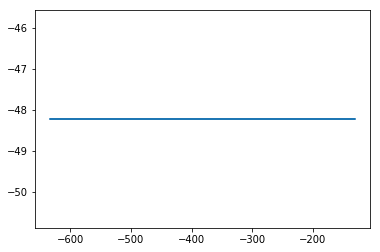

In [63]:
plt.plot(*np.array(trajectory).T)